# Solid Element Responses (Pyvista)

In [1]:
import openseespy.opensees as ops

import opstool as opst
import opstool.vis.pyvista as opsvis


In [2]:
opst.load_ops_examples("Dam-Brick")

ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
_ = opst.pre.gen_grav_load(direction="Z", factor=-9.81)

In [3]:
on_notebook = True
jupyter_backend = "static"
# on_notebook = False
# jupyter_backend = None

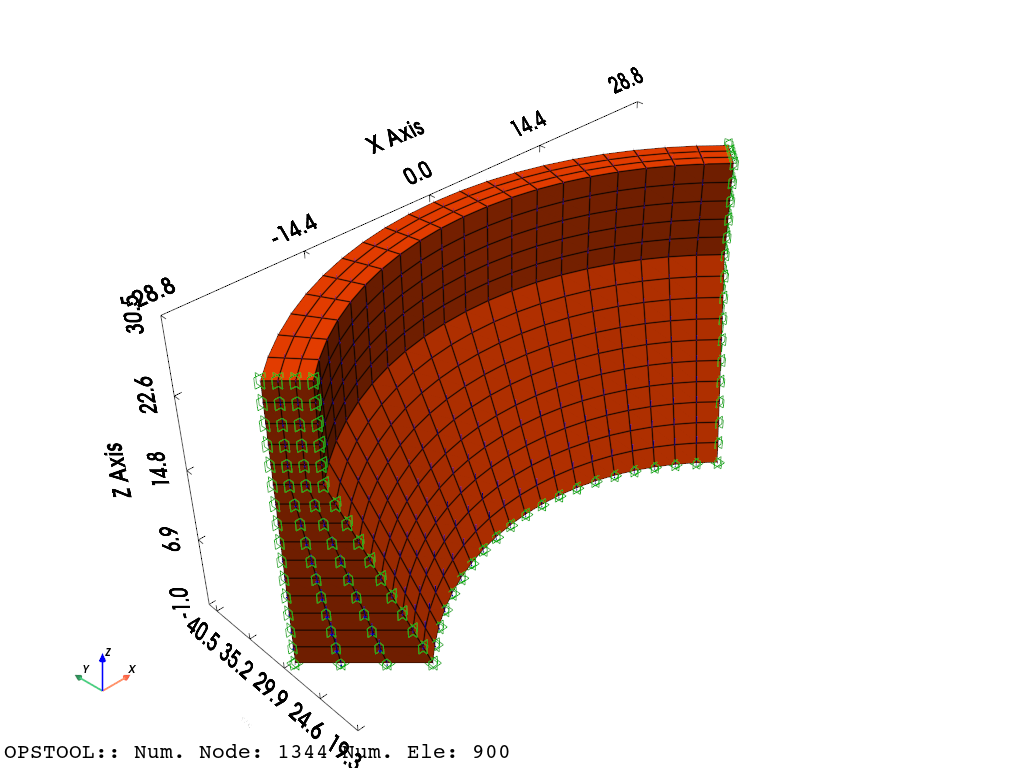

In [4]:
opsvis.set_plot_props(point_size=0, line_width=3, notebook=on_notebook)
fig = opsvis.plot_model(show_nodal_loads=True, show_ele_loads=True, show_outline=True)
fig.show(jupyter_backend=jupyter_backend)
# fig.show()

## Results visualization

In [5]:
ops.constraints("Transformation")
ops.numberer("RCM")
ops.system("BandGeneral")
ops.test("NormDispIncr", 1.0e-12, 6, 2)
ops.algorithm("Linear")
ops.integrator("LoadControl", 0.1)
ops.analysis("Static")

In [6]:
ODB = opst.post.CreateODB(
    odb_tag=1,
    compute_mechanical_measures=True,  # compute stress measures, strain measures, etc.
    project_gauss_to_nodes="copy",  # project gauss point responses to nodes, optional ["copy", "average", "extrapolate"]
)
for _ in range(10):
    ops.analyze(1)
    ODB.fetch_response_step()
ODB.save_response()

OPSTOOL ::  All responses data with _odb_tag = 1 saved in .opstool.output/RespStepData-1.nc!

OPSTOOL ::  Loading response data from .opstool.output/RespStepData-1.nc ...

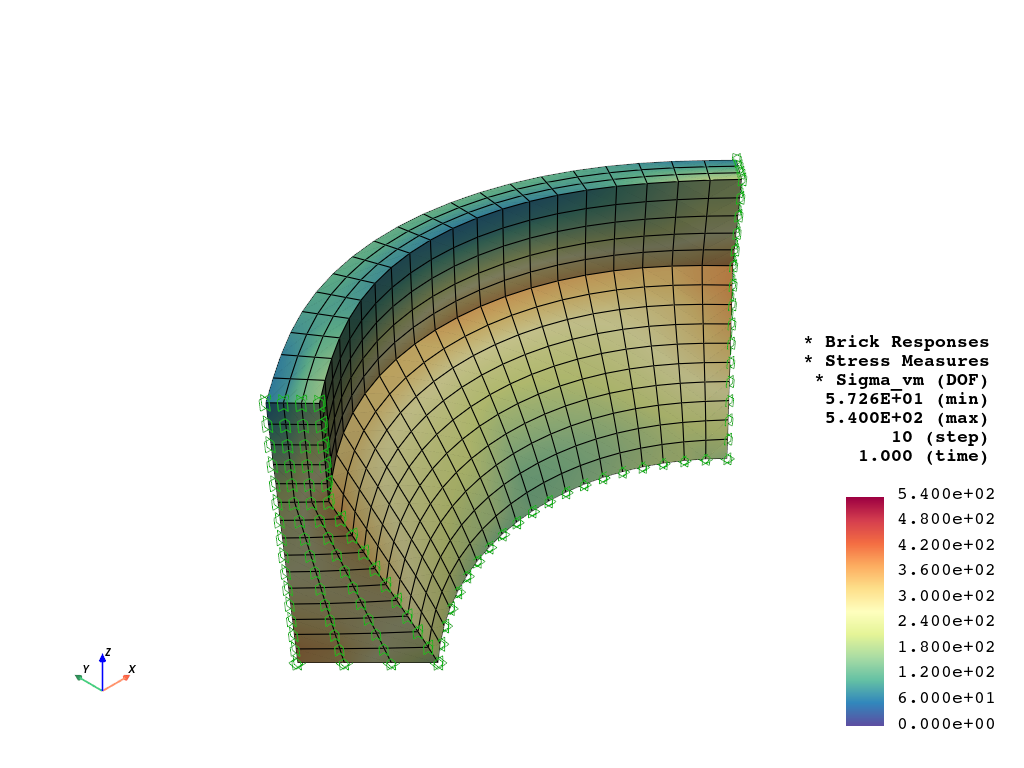

In [7]:
opsvis.set_plot_props(cmap="Spectral_r", point_size=0.0)

fig = opsvis.plot_unstruct_responses(
    odb_tag=1,
    slides=False,
    step="absMax",
    ele_type="Brick",
    resp_type="StressesAtNodes",  # or "stressesAtGauss", "strainsAtNodes", project_gauss_to_nodes needs to be set prior
    resp_dof="sigma_vm",
    show_defo=True,
    defo_scale="auto",
    show_model=True,
)
fig.show(jupyter_backend=jupyter_backend)
# fig.show()

OPSTOOL ::  Loading response data from .opstool.output/RespStepData-1.nc ...

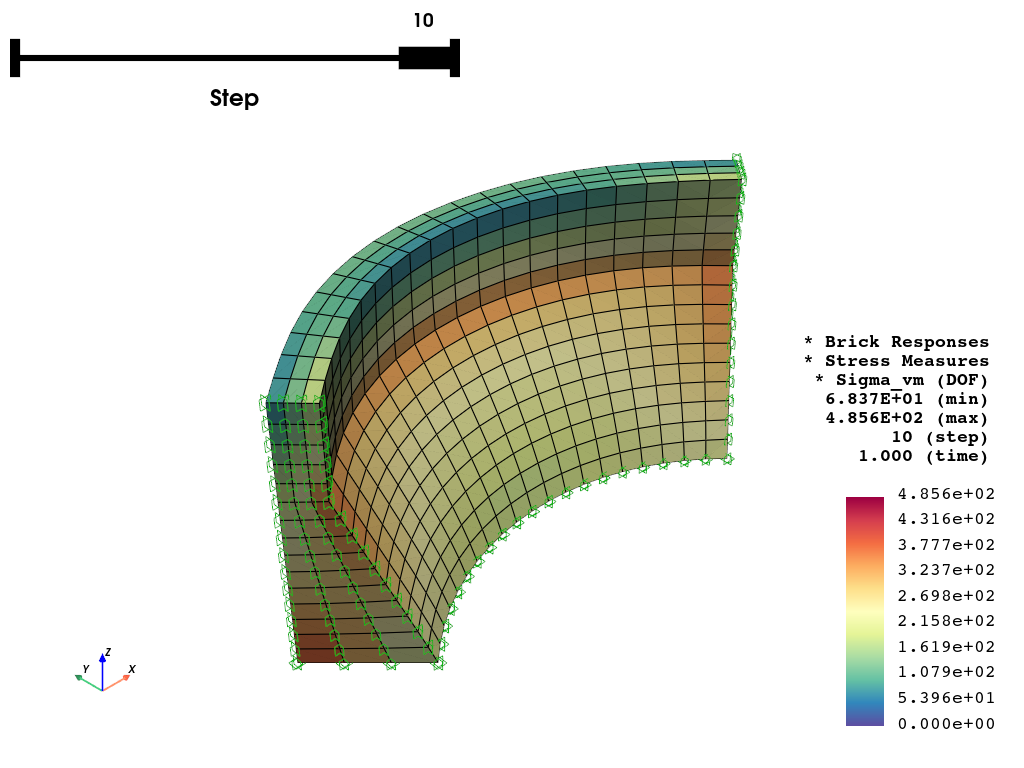

In [8]:
fig = opsvis.plot_unstruct_responses(
    odb_tag=1,
    slides=True,
    ele_type="Brick",
    resp_type="stresses",  # at Gauss points, it will be averaged over the element
    resp_dof="sigma_vm",
    show_model=False,
    show_defo=True,
    defo_scale="auto",
)
fig.show(jupyter_backend=jupyter_backend)
# fig.show()

In [9]:
fig = opsvis.plot_unstruct_responses_animation(
    odb_tag=1,
    ele_type="Brick",
    resp_type="stressesAtNodes",  # at nodes
    resp_dof="sigma_vm",
    savefig="images/BrickRespAnimation.gif",
    framerate=2,
    show_model=True,
    show_defo=True,
    defo_scale="auto",
)
fig.close()

OPSTOOL ::  Loading response data from .opstool.output/RespStepData-1.nc ...

Animation has been saved as images/BrickRespAnimation.gif!


![BrickRespAnimation](images/BrickRespAnimation.gif)

## Interacting with Pyvista

Since version 1.0.18, opstool provides a function ``get_unstruct_responses_dataset`` that returns a pyvista [UnstructuredGrid](https://docs.pyvista.org/api/core/_autosummary/pyvista.unstructuredgrid#pyvista.UnstructuredGrid) so that you can take advantage of all the functionality on it.

In [10]:
import pyvista as pv

In [11]:
ugrid = opsvis.get_unstruct_responses_dataset(
    odb_tag=1, step="absMax", ele_type="Brick", resp_type="stressesAtNodes", resp_dof="sigma_vm", defo_scale=0.0
)
print(ugrid)
print(ugrid.active_scalars_name)

OPSTOOL ::  Loading response data from .opstool.output/RespStepData-1.nc ...

UnstructuredGrid (0x196150a3b20)
  N Cells:    900
  N Points:   1344
  X Bounds:   -2.828e+01, 2.828e+01
  Y Bounds:   1.980e+01, 4.000e+01
  Z Bounds:   0.000e+00, 3.000e+01
  N Arrays:   1
StressMeasuresAtNodes


In [12]:
ugrid["StressMeasuresAtNodes"]

pyvista_ndarray([184.75853 , 173.28473 , 273.74048 , ...,  62.418205,
                  57.354465,  57.262924], dtype=float32)

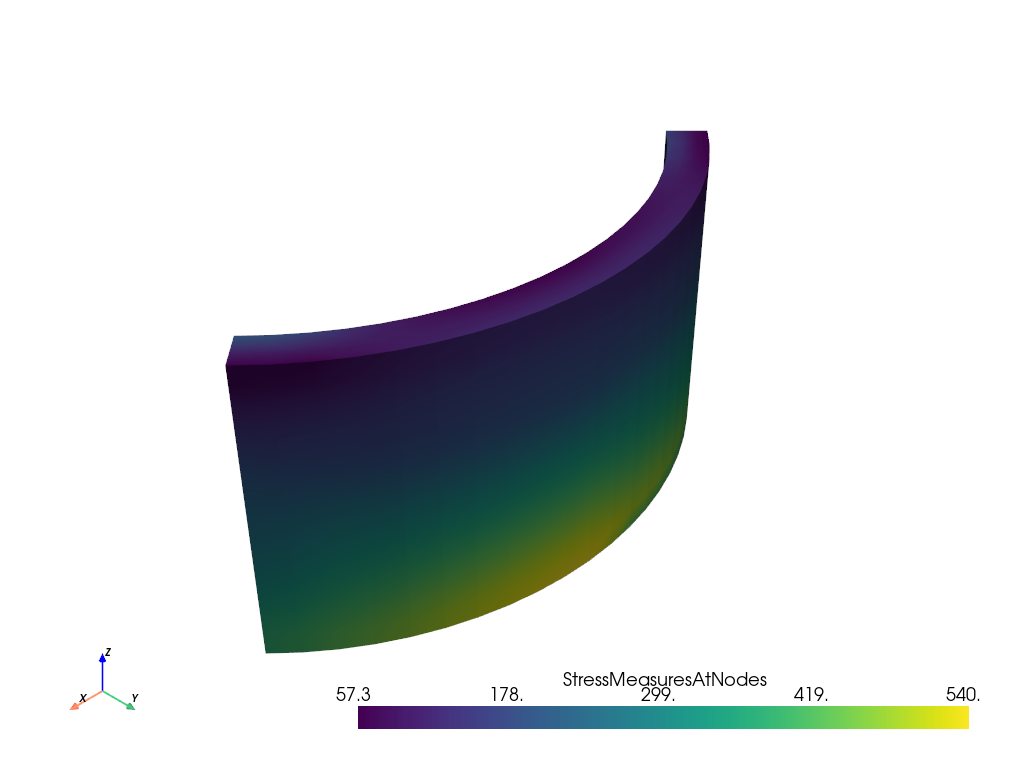

In [13]:
ugrid.plot(jupyter_backend=jupyter_backend)

### Plot on line

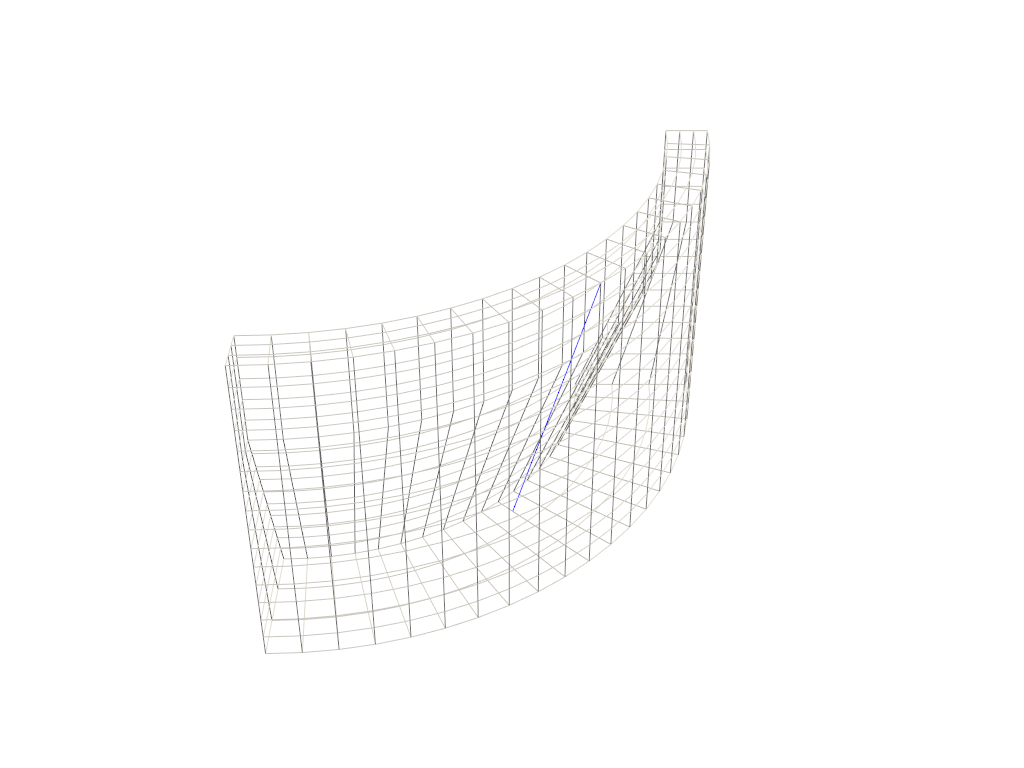

In [14]:
pa = (0, 30, 0)
pb = (0, 40, 30)
# Preview how this line intersects this mesh
line = pv.Line(pa, pb)

p = pv.Plotter()
p.add_mesh(ugrid, style="wireframe", color="w")
p.add_mesh(line, color="b")
p.show(jupyter_backend=jupyter_backend)

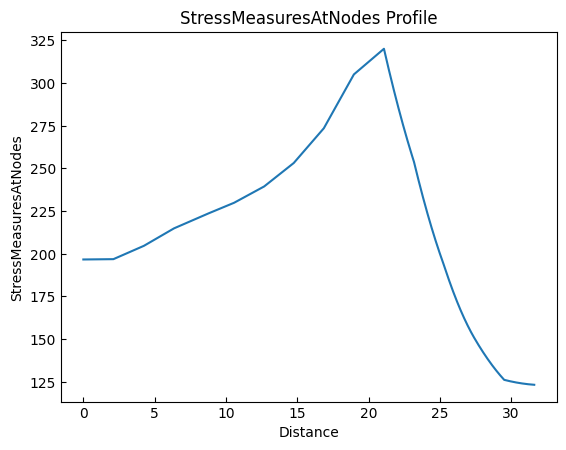

In [15]:
ugrid.plot_over_line(pa, pb)

### Thresholding

In [16]:
threshed = ugrid.threshold([300, 600])

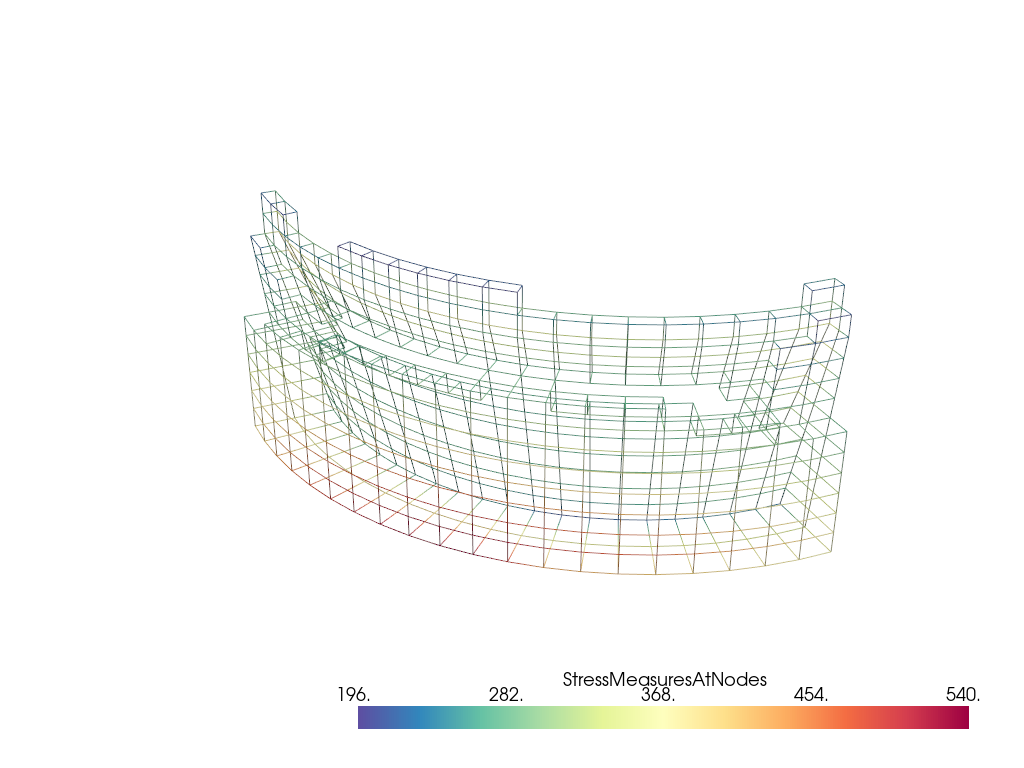

In [17]:
p = pv.Plotter()
p.add_mesh(threshed, style="wireframe", cmap="Spectral_r")
p.camera_position = [-2, 5, 3]
p.show(jupyter_backend=jupyter_backend)

More details can be found in the [PyVista Examples](https://docs.pyvista.org/examples/).